# RAdiology Data EXtraction (RADEX)

This notebook demonstrated how to use the functions in the `radex` module to extract structured information from radiology reports.

For demonstration, a sample dataset of 110 AI-generated thyroid ultrasound reports is also provided `data/synthetic_ultrasound_reports` to demonstrate the tool's main functions. These reports were generated using the freely accessible version of OpenAI's ChatGPT-3.5 and are split across two files, `ex_usreports_testing.csv` and `ex_usreports_testing.csv`.


by Lewis Howell

In [133]:
# Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from radex.preprocessing import clean_dataframe, remove_stopwords, remove_negated_phrases
from radex.radexpressions import evaluate_regex, get_regex_proximity, get_regex_wildcards, string_search
from radex.dfsearch import check_all_matches, search_dataframe, evaluate_sentences, list_to_string
from radex.expression import Expression

# Negex
from negex.negexPython.negex import sortRules

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in the datasets

In the `data/synthetic_ultrasound_reports` folder, there are two files: ex_usreports_testing and ex_usreports_validation. These are synthetic thyroid ultrasound reports generated by Chat GPT 3.5.
- ex_usreports_validation: Dataset we will use to develop and evaluate our search strategy
- ex_usreports_testing: Dataset we will use to test our final search strategy on unseen data

Both datasets are in CSV format and columns for the report and hand-labelled 'ground truth' findings we will try to predict:
- `report`: The text of the radiology report
- `Thyroid_mention`: The report mentions the thyroid
- `Normal_thyroid`: The thyroid is normal
- `Nodule_mention`: 1 or more thyroid nodules (>=1)
- `Multinodule`: Multiple thyroid nodules (>1)
- `U1`: British Thyroid Association U1 classification i.e. Normal thyroid
- `U2`: British Thyroid Association U2 classification i.e. Benign nodule
- `U3`: British Thyroid Association U3 classification i.e. Indeterminate nodule
- `U4`: British Thyroid Association U4 classification i.e. Suspicious nodule
- `U5`: British Thyroid Association U5 classification i.e. Malignant nodule
- `Single_nodule`: Single thyroid nodule (=1)
- `Altered_echotexture`: Echotexture of the thyroid is altered or thyroiditis indicated
- `Goitre`: Enlarged thyroid
- `Post-op`: The report mentions some sort of thyroid surgery


In [134]:
# Read the data
validation_data_path = 'data/synthetic_ultrasound_reports/ex_usreports_validation.csv'
test_data_path = 'data/synthetic_ultrasound_reports/ex_usreports_testing.csv'

df_validation = pd.read_csv(validation_data_path, index_col=None, encoding='utf-8')
df_validation.fillna('', inplace=True)

df_test = pd.read_csv(test_data_path, index_col=None, encoding='utf-8')
df_test.fillna('', inplace=True)

# Display the first 5 rows
with pd.option_context('display.max_colwidth', None):
    display(df_validation[['report']].head())
    
print('Number of reports in validation dataset =', len(df_validation))
print('Number of reports in test dataset =', len(df_test))

,report
0,"Ultrasound of the thyroid gland demonstrates a normal-appearing thyroid gland with no evidence of nodules, cysts or masses. The gland is symmetric with a homogenous echotexture."
1,"Ultrasound of the thyroid gland shows a solitary nodule in the right lobe measuring 1.5 cm in diameter. The nodule is solid and hypoechoic, with peripheral vascularity seen on Doppler imaging. No other significant abnormalities are identified."
2,"Ultrasound of the thyroid gland shows multiple small nodules in both lobes, the largest measuring 0.8 cm in diameter. The nodules are predominantly isoechoic and have a regular shape. No concerning features are seen."
3,"Ultrasound of the thyroid gland demonstrates a large, irregularly shaped nodule in the left lobe measuring 4 cm in diameter. The nodule is predominantly solid with some areas of cystic degeneration. Peripheral vascularity is seen on Doppler imaging. Fine needle aspiration biopsy is recommended."
4,Ultrasound of the thyroid gland shows a heterogeneous echotexture with multiple nodules in both lobes. The largest nodule measures 1.2 cm in diameter and is solid and hypoechoic. No suspicious features are seen. Clinical correlation is recommended.


Number of reports in validation dataset = 50
Number of reports in test dataset = 60


<Axes: >

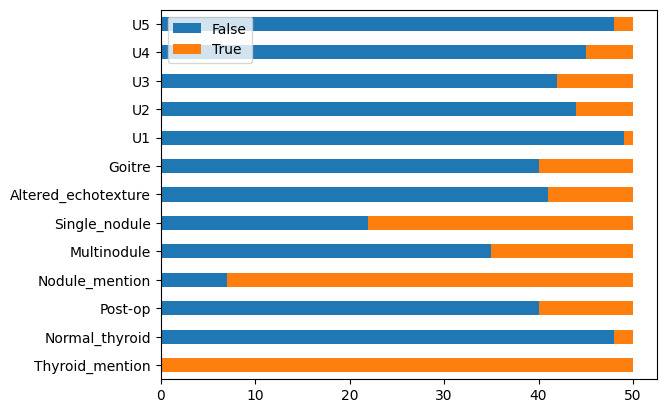

In [135]:
# Count the number of reports with each label. 
# We see there is a class imbalance in the dataset. This is not uncommon in medical datasets.

cols = df_test.columns.drop(['report', 'label'])
df_validation[cols].apply(pd.Series.value_counts).T.plot(kind='barh', stacked=True)

## Pre-processing
Before we can run our search strategy, we need to pre-process the data. This involves:

- Cleaning the data by removing punctuation and making all text lowercase
- Removing stopwords 
- Negation handling (Negex)

## Negex
The negex algorithm uses regular expressions to handle negation in text - Chapman et al. (2001). 
DOI: 10.1197/jamia.M0820

A python implementation is available at: [https://github.com/chapmanbe/negex/tree/master/negex.python] which was forked and included as a submodule in this repository.

The trigger terms are defined in the `negex_triggers.txt` file and can be modified as needed.

Negex uses a simple set of trigger terms indicating a clinical condition is negated or possibly negated, and determines which text falls within the scope of the negation. These add tags to the text output to indicate the negation status of the term:


| Tag       | Description                           |
|-----------|---------------------------------------|
| [PREN]    | Pre-negation rule tag                 |
| [POST]    | Post-negation rule tag                |
| [PREP]    | Pre possible negation tag             |
| [POSP]    | Post possible negation tag            |
| [PSEU]    | Pseudo negation tag                    |
| [CONJ]    | Conjunction tag                        |
| [PHRASE]  | Term is recognized from the term list, we search negation for but was NOT negated |
| [NEGATED] | Term was recognized from term list, and it was found being negated |
| [POSSIBLE]| Term was recognized from term list, and was found as possible negation |




In [136]:
rules_file = r"negex/negexPython/negex_triggers.txt"

with open(rules_file, encoding="utf-8") as rfile:
    rules = sortRules(rfile.readlines())
    
# Print the rules
for rule in rules:
    print(rule[0:3])

['sufficient to rule the patient out against', '', '[PREN]']
['adequate to rule the patient out against', '', '[PREN]']
['sufficient to rule the patient out for', '', '[PREN]']
['adequate to rule the patient out for', '', '[PREN]']
['sufficient to rule the patient out', '', '[PREN]']
['sufficient to rule him out against', '', '[PREN]']
['sufficient to rule her out against', '', '[PREN]']
['did rule the patient out against', '', '[PREN]']
['can rule the patinet out against', '', '[PREN]']
['adequate to rule the patient out', '', '[PREN]']
['no significant interval change', '', '[PSEU]']
['sufficient to rule him out for', '', '[PREN]']
['sufficient to rule her out for', '', '[PREN]']
['sufficient to rule out against', '', '[PREN]']
['ruled the patient out against', '', '[PREN]']
['as the secondary etiology for', '', '[CONJ]']
['did rule the patient out for', '', '[PREN]']
['can rule the patinet out for', '', '[PREN]']
['adequate to rule him out for', '', '[PREN]']
['adequate to rule her 

In [137]:
# Now we apply the negation handling to block out negated phrases. The negation handles each sentence separately.
# In this example, the text 'observed nodules' is negated 
# but the text 'small nodules is the left lobe' is out of scope of the negation

text = 'Ultrasound of the thyroid gland shows no observed nodules in the right lobe but several small nodules in the left lobe. No evidence of malignancy'

print('Original text:', text)
print('Output text:', remove_negated_phrases(text, rules=rules, verbose=True))




Original text: Ultrasound of the thyroid gland shows no observed nodules in the right lobe but several small nodules in the left lobe. No evidence of malignancy
Tagged sentence: Ultrasound of the thyroid gland shows [PREN]no[PREN] observed nodules in the right lobe [CONJ]but[CONJ] several small nodules in the left lobe
Negated phrases to be removed: ['observed nodules in the right lobe']
Sentence with negated phrases removed: Ultrasound of the thyroid gland shows no XXXXX but several small nodules in the left lobe
Tagged sentence: [PREN]no evidence[PREN] of malignancy
Negated phrases to be removed: ['of malignancy']
Sentence with negated phrases removed: no evidence XXXXX
Output text: Ultrasound of the thyroid gland shows no XXXXX but several small nodules in the left lobe. no evidence XXXXX


## Stopwords

Stopwords are common words that are often removed from text before processing. This can help reduce the size of the data and improve the performance of NLP algorithms.

We can use the `nltk` (Natural Language Toolkit) library which provides a list of stopwords for many languages, or choose to use a custom list of stopwords.

For convenience, the `radex` module includes a list of stopwords for English (from NLTK).

In [138]:
# Remove stopwords (by default, this uses nltk stopwords)
stop_words = pd.read_csv('data/stopwords.csv').T.values[0]
exceptions = ["no", "not", "nor", "few", "other"] # don't remove these words 
stop_words = [word for word in stop_words if word not in exceptions]

print('Stop words:', stop_words)

Stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'more', 'most', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 

## Clean the dataframe
Apply the pre-processing steps to the dataframe and save the cleaned text to a new column.


In [139]:
# Clean the data (validation and test datasets)
df_validation['report_original'] = df_validation['report']
df_test['report_original'] = df_test['report']

df_validation = clean_dataframe(df_validation, 'report', 
                          drop_duplicates=True, # drop duplicate entries
                          drop_nulls=True, # drop empty reports
                          drop_negatives=rules, # remove negated phrases
                          drop_ambiguous=True, # remove phrases with ambiguous negation
                          drop_stopwords=stop_words, # remove stopwords
                          )

df_test = clean_dataframe(df_test, 'report', 
                          drop_duplicates=True, # drop duplicate entries
                          drop_nulls=True, # drop empty reports
                          drop_negatives=rules, # remove negated phrases
                          drop_ambiguous=True, # remove phrases with ambiguous negation
                          drop_stopwords=stop_words, # remove stopwords
                          )

with pd.option_context('display.max_colwidth', None):
    display(df_validation[['report_original', 'report', 'label']].head())


,report_original,report,label
0,"Ultrasound of the thyroid gland demonstrates a normal-appearing thyroid gland with no evidence of nodules, cysts or masses. The gland is symmetric with a homogenous echotexture.",ultrasound thyroid gland demonstrates normal appearing thyroid gland no evidence XXXXX. gland symmetric homogenous echotexture,thy normal-thy
1,"Ultrasound of the thyroid gland shows a solitary nodule in the right lobe measuring 1.5 cm in diameter. The nodule is solid and hypoechoic, with peripheral vascularity seen on Doppler imaging. No other significant abnormalities are identified.",ultrasound thyroid gland shows solitary nodule right lobe measuring 1. 5 cm diameter. nodule solid hypoechoic peripheral vascularity seen doppler imaging. no XXXXX,thy nodule
2,"Ultrasound of the thyroid gland shows multiple small nodules in both lobes, the largest measuring 0.8 cm in diameter. The nodules are predominantly isoechoic and have a regular shape. No concerning features are seen.",ultrasound thyroid gland shows multiple small nodules lobes largest measuring 0. 8 cm diameter. nodules predominantly isoechoic regular shape. no XXXXX,thy nodule nodules
3,"Ultrasound of the thyroid gland demonstrates a large, irregularly shaped nodule in the left lobe measuring 4 cm in diameter. The nodule is predominantly solid with some areas of cystic degeneration. Peripheral vascularity is seen on Doppler imaging. Fine needle aspiration biopsy is recommended.",ultrasound thyroid gland demonstrates large irregularly shaped nodule left lobe measuring 4 cm diameter. nodule predominantly solid areas cystic degeneration. peripheral vascularity seen doppler imaging. fine needle aspiration biopsy recommended,thy nodule
4,Ultrasound of the thyroid gland shows a heterogeneous echotexture with multiple nodules in both lobes. The largest nodule measures 1.2 cm in diameter and is solid and hypoechoic. No suspicious features are seen. Clinical correlation is recommended.,ultrasound thyroid gland shows heterogeneous echotexture multiple nodules lobes. largest nodule measures 1. 2 cm diameter solid hypoechoic. no suspicious XXXXX. clinical correlation recommended,thy thyroiditis nodules nodule


## String searching with RADEX
RADEX uses regular expressions to search for terms in the text without requiring knowledge of their syntax. The `radex` module provides a set of functions to convert search terms to regular expressions and apply them to text.

The main features used to define searches are:
- Wildcards * and ? 
- Proximity operator ~X to search for words that are near each other 
- Boolean operators AND, OR, and NOT to compound searches

Wildcards *, ?

- The asterisk (*) represents any group of characters, including no character.
- The question mark (?) represents zero or one character.

In [140]:
# Wildcard search using regex (regular expressions)
# The * wildcard matches any number of characters and can be used at the start, middle or end of a word
# The ? wildcard matches zero or one of any character and is most useful for variations in spelling

# e.g. 'thyr* matches 'thyroid' and 'thyroiditis' but not 'parathyroid'
candidate = "There are no thyroid nodules present in the images but some signs of thyroiditis are present. The parathyroid gland is normal in size and echotexture. "
expression = 'thyr*'

# Convert the expression to a regular expression
regex = get_regex_wildcards(expression)
print('Regular expression:', regex)

# Evaluate the regular expression on the candidate text
evaluate_regex(candidate, regex)

Regular expression: \bthyr\w*\b


[('thyroid', 13, 20), ('thyroiditis', 69, 80)]

In [141]:
# e.g. 'goit?r? matches 'goitre' and 'goiter'
candidate = "Neck is enlarged indicating a goitre/goiter. The thyroid gland is diffusely enlarged with a nodular appearance."
expression = 'goit?r?'

# Convert the expression to a regular expression
regex = get_regex_wildcards(expression)
print('Regular expression:', regex)

# Evaluate the regular expression on the candidate text
evaluate_regex(candidate, regex)

Regular expression: \bgoit.?r.?\b


[('goitre', 30, 36), ('goiter', 37, 43)]

Proximity operator ~X, ~~X

By default, the proximity operator only applies to terms in the same sentence.

- The unidirectional proximity operator ~X, THENX
    - Search for terms that are within X words of each other in the order they are specified.
- The bidirectional proximity operator ~~X, NEARX
    - Search for terms that are within X words of each other in any order.

In [142]:
candidate = "There are no thyroid nodules present in the images but some signs of thyroiditis are present. The parathyroid gland is normal in size and echotexture. "
word1 = "nodules"
word2 = "thyroid"
max_distance = 3

regex = get_regex_proximity(word1, word2, max_distance, direction='centre') 
print('Regular expression:', regex)

evaluate_regex(candidate, regex)

Regular expression: \bnodules\b\W+(?:\w+\W+){0,3}?\bthyroid\b|\bthyroid\b\W+(?:\w+\W+){0,3}?\bnodules\b


[('thyroid nodules', 13, 28)]

In [143]:
# Bidirectional search i.e. thyroid is within 4 words of nodules or vice versa
candidate = "There are several nodules in the right thyroid."
expression = 'thyroid ~~4 nodules'

print('Ex1:', candidate, '\n\tExpression:', expression, '\n\tResult:', string_search(candidate, expression))

# Unidirectional search i.e. thyroid is before nodules and within 4 words
candidate = "There are several nodules in the right thyroid. "
expression = 'thyroid ~4 nodules'

print('Ex2:', candidate, '\n\tExpression:', expression, '\n\tResult:', string_search(candidate, expression))

# Search with too large a distance
candidate = "There are several nodules in the right lobe of the thyroid."
expression = 'nodules ~4 thyroid'

print('Ex3:', candidate, '\n\tExpression:', expression, '\n\tResult:', string_search(candidate, expression))

# If we remove stopwords, proximity searching is generally more robust as it is less sensitive to variations in wording
candidate = "There are several nodules in the right lobe of the thyroid."
candidate = remove_stopwords(candidate, stopwords=stop_words) # This removes stopwords
expression = 'nodules ~4 thyroid'

print('Ex4:', candidate, '\n\tExpression:', expression, '\n\tResult:', string_search(candidate, expression))

Ex1: There are several nodules in the right thyroid. 
	Expression: thyroid ~~4 nodules 
	Result: (True, [('nodules in the right thyroid', 18, 46)])
Ex2: There are several nodules in the right thyroid.  
	Expression: thyroid ~4 nodules 
	Result: (False, [])
Ex3: There are several nodules in the right lobe of the thyroid. 
	Expression: nodules ~4 thyroid 
	Result: (False, [])
Ex4: There several nodules right lobe thyroid. 
	Expression: nodules ~4 thyroid 
	Result: (True, [('nodules right lobe thyroid', 14, 40)])


In [144]:
# We can also combine proximity and wildcard searches to build up more complex expressions
candidate = "There are several nodules present in the right lobe of the thyroid. Multinodular goitre in right neck."
expression = '*nodule* ~4 right'

print('Ex3:', candidate, '\n\tExpression:', expression, '\n\tResult:', string_search(candidate, expression))

Ex3: There are several nodules present in the right lobe of the thyroid. Multinodular goitre in right neck. 
	Expression: *nodule* ~4 right 
	Result: (True, [('nodules present in the right', 18, 46)])


Logical operators
- & / ^ / AND for logial AND, 
- | / v / OR for logial OR,
- ! / ¬ / NOT for logical NOT
- EXCEPT which is defined as &¬, i.e. AND NOT 

In [145]:
# We can also combine with operators like AND, OR, and NOT to create more complex searches
# The syntax for this uses:
# & / ^ / AND for logial AND, 
# | / v / OR for logial OR,
# ! / ¬ / NOT for logical NOT
# Also implemented is EXCEPT which is defined as &¬, i.e. AND NOT 

# To do this, we define an expression object to define the logic of the search. 
# This ensures that the rules for boolean logic are followed, even when brackets are not used
# i.e. AND has higher precedence than OR, and NOT has higher precedence than AND and OR
# This is similar to how division has higher precedence than addition and subtraction.
expr = Expression()

# We can then use this to parse a string into a nested list
input_str = "(thyroi* & nodul*) EXCEPT no nodul*" 
result = expr.parse_string(input_str)
print(result)

[[['thyroi* ', '&', 'nodul*'], '&', ['¬', 'no nodul*']]]


In [146]:
# We might want this as a string to display to the user e.g.
print(list_to_string(expr.parse_string('¬a | b & c')))

print(list_to_string(expr.parse_string('nodul* OR thyroi* NEAR2 goitre*')))

(((¬, a), |, (b, &, c)))
((nodul*, |, thyroi* ~~2 goitre*))


In [147]:
# We can then use this to do a logical search, where each statement is evaluated in turn
input_str = 'cyst* EXCEPT(thyroglo* THEN1 cyst?)'
candidate = "evidence of thyroglossal cyst"
expression = expr.parse_string(input_str)
print(list_to_string(expression))

evaluate_sentences(candidate, expression, verbose=True) # v=True prints the logical search steps
expression


((cyst*, &, (¬, (, thyroglo* ~1 cyst?, ))))

Sentence: evidence of thyroglossal cyst
cyst* => True [('cyst', 25, 29)]
thyroglo* ~1 cyst? => True [('thyroglossal cyst', 12, 29)]
¬, thyroglo* ~1 cyst? => not True => False
cyst*, &, (¬, (, thyroglo* ~1 cyst?, )) => True and False => False
(cyst*, &, (¬, (, thyroglo* ~1 cyst?, ))) => False => False


[['cyst* ', '&', ['¬', '(', 'thyroglo* ~1 cyst?', ')']]]

In [148]:
# Each sentence is evaluated separately until a match is found
expr = Expression()
input_str = 'nodu* ~~2 thyroid'
candidate = "The parathyroid gland is normal in size and echotexture. There are no thyroid nodules present in images but some signs of thyroiditis are present. "
expression = expr.parse_string(input_str, verbose=True)
print(expression)

output = evaluate_sentences(candidate, expression, verbose=True) # v=True prints the logical search steps
print('\nResult:', output)

Input string:  nodu* ~~2 thyroid
['nodu* ~~2 thyroid']

Sentence: The parathyroid gland is normal in size and echotexture
nodu* ~~2 thyroid => False []
nodu* ~~2 thyroid => False => False

Sentence:  There are no thyroid nodules present in images but some signs of thyroiditis are present
nodu* ~~2 thyroid => True [('thyroid nodules', 13, 28)]
nodu* ~~2 thyroid => True => True

Result: True


In [149]:
# If we want to check if a candidate string matches the expression, we can use the check_all_matches function
# This is useful for debugging
input_str = 'thy*'
candidate = "Evidence of previous thyroidectomy. There are no thyroid nodules present in the remaining tissue but some signs of thyroiditis are present. The thyroid gland is normal in size and echotexture. "

expression = expr.parse_string(input_str)
check_all_matches(candidate, expression)

{'thy*': (True,
  [('thyroidectomy', 21, 34),
   ('thyroid', 13, 20),
   ('thyroiditis', 79, 90),
   ('thyroid', 4, 11)])}

## DataFrame search

- Define a list of search terms
- Apply the search terms to the dataframe and save the results 

In [150]:
# Usually we want to search a whole table rather than a single item
# We can do this using the search_dataframe function

# Lets try a simple search for thyroid nodules. If we try nod* this should match 'nodules' and 'nodule'
expression = 'nod*'

df_predicted = df_validation.copy() # make a copy of the dataframe to hold the predictions
df_actual = df_validation.copy() # make a copy of the dataframe to hold the actual labels

In [151]:
# Run the search
# debug_column=True includes the search steps in a new column
df_predicted = search_dataframe(df_predicted, column='report', expression=expr.parse_string(expression), 
                            new_column_name='Nodule_mention_predicted', debug_column=True)

# Display the results
with pd.option_context('display.max_colwidth', None):
    display(df_predicted[['report_original', 'Nodule_mention_predicted','Nodule_mention_predicted_matches']].head()) 
    

,report_original,Nodule_mention_predicted,Nodule_mention_predicted_matches
0,"Ultrasound of the thyroid gland demonstrates a normal-appearing thyroid gland with no evidence of nodules, cysts or masses. The gland is symmetric with a homogenous echotexture.",False,"{'nod*': (False, [])}"
1,"Ultrasound of the thyroid gland shows a solitary nodule in the right lobe measuring 1.5 cm in diameter. The nodule is solid and hypoechoic, with peripheral vascularity seen on Doppler imaging. No other significant abnormalities are identified.",True,"{'nod*': (True, [('nodule', 40, 46), ('nodule', 0, 6)])}"
2,"Ultrasound of the thyroid gland shows multiple small nodules in both lobes, the largest measuring 0.8 cm in diameter. The nodules are predominantly isoechoic and have a regular shape. No concerning features are seen.",True,"{'nod*': (True, [('nodules', 46, 53), ('nodules', 0, 7)])}"
3,"Ultrasound of the thyroid gland demonstrates a large, irregularly shaped nodule in the left lobe measuring 4 cm in diameter. The nodule is predominantly solid with some areas of cystic degeneration. Peripheral vascularity is seen on Doppler imaging. Fine needle aspiration biopsy is recommended.",True,"{'nod*': (True, [('nodule', 63, 69), ('nodule', 0, 6)])}"
4,Ultrasound of the thyroid gland shows a heterogeneous echotexture with multiple nodules in both lobes. The largest nodule measures 1.2 cm in diameter and is solid and hypoechoic. No suspicious features are seen. Clinical correlation is recommended.,True,"{'nod*': (True, [('nodules', 66, 73), ('nodule', 8, 14)])}"


<Figure size 300x300 with 0 Axes>

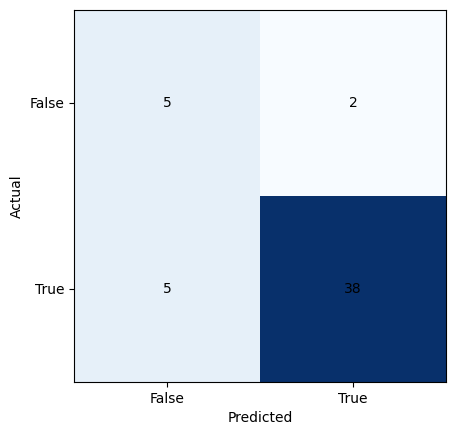

In [152]:
# Lets see how this compares to the actual labels

# The most informative way to display the results is to create a confusion matrix
# This shows the number of true positives, false positives, true negatives, and false negatives
# e.g.
def confusion_matrix(actual, predicted):
    TP = sum((actual == 1) & (predicted == 1))
    FP = sum((actual == 0) & (predicted == 1))
    TN = sum((actual == 0) & (predicted == 0))
    FN = sum((actual == 1) & (predicted == 0))
    return np.array([[TN, FP], [FN, TP]])

########

cm = confusion_matrix(df_actual['Nodule_mention'], df_predicted['Nodule_mention_predicted'])

# Display the confusion matrix
plt.figure(figsize=(3,3))
plt.matshow(cm, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['False', 'True'])
plt.gca().xaxis.set_ticks_position('bottom')
plt.yticks([0, 1], ['False', 'True'])

for (i, j), val in np.ndenumerate(cm): # Show the values in the matrix
    plt.text(j, i, f'{val}', ha='center', va='center')



Not bad, but we got a few false negatives and false positives. We can use the `radex` approach to refine our search strategy.

In [153]:
# Lets look at the rows we got wrong and try to improve the search expression

# get wrong predictions 
df_wrong_predictions = df_predicted[df_actual['Nodule_mention'] != df_predicted['Nodule_mention_predicted']]

print('Number of wrong predictions:', len(df_wrong_predictions))

# Display the results
with pd.option_context('display.max_colwidth', None):
    display(df_wrong_predictions[['report_original', 'Nodule_mention_predicted','Nodule_mention','Nodule_mention_predicted_matches']]) 

Number of wrong predictions: 7


,report_original,Nodule_mention_predicted,Nodule_mention,Nodule_mention_predicted_matches
8,Ultrasound of the thyroid gland shows a complex cyst in the right lobe measuring 2.5 cm in diameter. No internal vascularity seen on Doppler imaging. No fine needle aspiration biopsy is neeeded.,False,True,"{'nod*': (False, [])}"
9,Ultrasound of the thyroid gland demonstrates a multinodular goiter across both lobes.,False,True,"{'nod*': (False, [])}"
22,Ultrasound of the thyroid gland shows a small hypoechoic cyst in the right lobe measuring 0.8 cm in diameter. Partial thyroid with right lobe removed. No suspicious features are seen.,False,True,"{'nod*': (False, [])}"
35,Ultrasound of the thyroid gland appears normal in echotexture and size. No focal abnormalities. Lymph node examination normal.,True,False,"{'nod*': (True, [('node', 6, 10)])}"
37,Ultrasound of the thyroid gland appears normal. Lymph node examination normal.,True,False,"{'nod*': (True, [('node', 6, 10)])}"
46,The thyroid gland appears to be enlarged showing evidence of mng.,False,True,"{'nod*': (False, [])}"
49,Ultrasound of the thyroid gland indicated thyroiditis and MNG seen in both lobes. Correlation with clinical data is recommended.,False,True,"{'nod*': (False, [])}"


Report 8: False negative. This report refers to a cyst without any mention of a nodule. We can add a search term for cysts to our search strategy.

Report 9: False negative. This mentions a multinodular goitre, which we can add to our search strategy.

Report 22: False negative. This mentions a cyst too.

Report 35: False positive. This mentions a lymph node exam, which is picked up by our broad wildcard search for node*. 

Report 35: False positive. Same as above.

Report 37: False positive. Same as above.

Report 46: False negative. This mentions 'mng' which is an abbreviation for multinodular goitre, suggesting thyroid nodules

Report 49: False negative. Same as above.

In [154]:
# Lets try modifying our search slightly to see if we can improve the results
expression = '*nodul* OR cyst* | mng' # This will catch 'nodules' and 'nodule' 'multinodular' but NOT 'node'

# N.b. there are many ways we could try to improve the search, this is just one example.
# e.g. expression = 'nod* OR multinod* OR cyst* EXCEPT lymph node'
# might also work 

df_predicted = df_validation.copy() # make a copy of the dataframe to hold the predictions
df_predicted = search_dataframe(df_predicted, column='report', expression=expr.parse_string(expression), 
                            new_column_name='Nodule_mention_predicted', debug_column=True)

# get wrong predictions 
df_wrong_predictions = df_predicted[df_predicted['Nodule_mention_predicted'] != df_actual['Nodule_mention']]  

print('Number of wrong predictions:', len(df_wrong_predictions))

# Display the results
with pd.option_context('display.max_colwidth', None):
    display(df_wrong_predictions[['report_original', 'Nodule_mention_predicted','Nodule_mention','Nodule_mention_predicted_matches']].head()) 

Number of wrong predictions: 1


,report_original,Nodule_mention_predicted,Nodule_mention,Nodule_mention_predicted_matches
28,Ultrasound of the thyroid gland shows a small hypoechoic node in the left lobe measuring 0.9 cm in diameter. There is evidence of prior thyroid surgery with surgical bed identified in the left lobe. No suspicious features are seen.,False,True,"{'*nodul*': (False, []), 'cyst*': (False, []), 'mng': (False, [])}"


Only 1 wrong prediction now. Report 28 is now a False Negative. The reporter has described the nodule as a thyroid node. To distinguish this from a lymph node we could use a proximity search for 'thyroid' and 'node' e.g. `'thyroid NEAR4 node'`

Note, it may not always be possible to achieve 100% accuracy with a search strategy. It is important to consider the trade-off between sensitivity and specificity and the implications of false positives and false negatives in the context of the clinical question.

In [155]:
# Now can then calculate metrics like precision, recall, and F1 score
# e.g. 
def calc_scores(confusion_matrix, display=False):
    
    tn, fp, fn, tp = confusion_matrix.flatten() # True negatives, False positives, False negatives, True positives
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    if display:
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision/ PPV: {precision:.2f}')
        print(f'Sensitivity/ Recall/ TPR: {recall:.2f}')
        print(f'Specificity/ TNR: {specificity:.2f}')
        print(f'F1: {f1_score:.2f}')
        print(f'TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}')
        print('\n')
        
    return {'accuracy': accuracy, 
            'precision': precision, 
            'recall': recall, 
            'specificity': specificity, 
            'f1_score': f1_score}


In [156]:
cm = confusion_matrix(df_actual['Nodule_mention'], df_predicted['Nodule_mention_predicted'])
scores = calc_scores(cm, display=True)

Accuracy: 0.98
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 0.98
Specificity/ TNR: 1.00
F1: 0.99
TP: 42, FP: 0, FN: 1, TN: 7




## Testing
To ensure our search strategy is robust enough to generalise to unseen data, we will test it on the `ex_usreports_testing` dataset which we have not used to develop our search strategy.



In [157]:
expression = '*nodul* OR cyst* | mng'

df_test = search_dataframe(df_test, column='report', expression=expr.parse_string(expression), 
                            new_column_name='Nodule_mention_predicted', debug_column=True)

cm = confusion_matrix(df_test['Nodule_mention'], df_test['Nodule_mention_predicted'])
scores = calc_scores(cm, display=True)

Accuracy: 0.98
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 0.96
Specificity/ TNR: 1.00
F1: 0.98
TP: 27, FP: 0, FN: 1, TN: 32




## Multi-label searching

- Use the `radex` module to define more complex search strategies

In [158]:
# We can build up a set of searches to apply to the dataset for multilabel classification

searches = {

    'Thyroid_mention': 'thyroid',
    'Normal_thyroid': 'normal~2thyroid',
    'Post-op':'*thyroidectomy | lobectomy | surg* | resect* | resection* | incomplete~~2thyroid | partial~~2thyroid | post?op',
    'Nodule_mention': 'nodul* | thyroid~~4node | thyroid~~2cyst*',
    'Multinodule': 'multi?nodul* | mng | nodules | thyroid~~2cysts | thyroid ~~2 nodes',
    'Altered_echotexture':'thyroiditis | grav?s | heterogen* echotexture | inflamed* ~~2thyroid',
    'Goitre': 'goit?r? | mng | enlarge*~~3thyroid',
    'U1': '_u1',
    'U2': '_u2',
    'U3': '_u3',
    'U4': '_u4',
    'U5': '_u5',
}
# Run the searches
for filter_name, expression in searches.items():    
    expression = expr.parse_string(expression)
    search_dataframe(df_predicted, column='report', expression=expression, new_column_name=filter_name, debug_column=True)
    

In [159]:
# Apply postprocessing logic. This can increase the accuracy and consistency of the predictions by enforcing logical rules.
# We can also derive additional columns e.g. lack of disease implies normal

# Normal thyroid if there was a thyroid examination and no thyroid pathologies are found
df_predicted['Normal_thyroid'] = (df_predicted['Thyroid_mention'] & \
                                ~(df_predicted['Nodule_mention'] | \
                                    df_predicted['Post-op'] | \
                                    df_predicted['Multinodule'] | \
                                    df_predicted['Altered_echotexture'] | \
                                    df_predicted['Goitre'] ))
            
# Nodules -> Nodule
df_predicted['Nodule_mention'] = df_predicted['Nodule_mention'] | df_predicted['Multinodule'] | \
                                    df_predicted['U2'] | df_predicted['U3'] | df_predicted['U4'] | df_predicted['U5'] 
        
# Multiple BTA classes -> Multinodule
df_predicted['Multinodule'] = df_predicted['Multinodule'] | \
                                (df_predicted['U2'] & df_predicted['U3']) | \
                                (df_predicted['U2'] & df_predicted['U4']) | \
                                (df_predicted['U2'] & df_predicted['U5']) | \
                                (df_predicted['U3'] & df_predicted['U4']) | \
                                (df_predicted['U3'] & df_predicted['U5']) | \
                                (df_predicted['U4'] & df_predicted['U5'])
                                            

# Nodule & ¬Nodules -> single nodule
df_predicted['Single_nodule'] = ~df_predicted['Multinodule'] & df_predicted['Nodule_mention'] 

In [160]:
# # save outputs to csv (uncomment to save)
# df_predicted.to_csv('output.csv', index=False)

In [161]:
# Print out the scores for each class
for col in cols:
    print(col)
    cm = confusion_matrix(df_actual[col], df_predicted[col])
    scores = calc_scores(cm, display=True)

Thyroid_mention
Accuracy: 1.00
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 1.00
Specificity/ TNR: nan
F1: 1.00
TP: 50, FP: 0, FN: 0, TN: 0


Normal_thyroid
Accuracy: 0.96
Precision/ PPV: 0.50
Sensitivity/ Recall/ TPR: 1.00
Specificity/ TNR: 0.96
F1: 0.67
TP: 2, FP: 2, FN: 0, TN: 46


Post-op
Accuracy: 1.00
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 1.00
Specificity/ TNR: 1.00
F1: 1.00
TP: 10, FP: 0, FN: 0, TN: 40


Nodule_mention
Accuracy: 0.96
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 0.95
Specificity/ TNR: 1.00
F1: 0.98
TP: 41, FP: 0, FN: 2, TN: 7


Multinodule
Accuracy: 0.98
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 0.93
Specificity/ TNR: 1.00
F1: 0.97
TP: 14, FP: 0, FN: 1, TN: 35


Single_nodule
Accuracy: 0.94
Precision/ PPV: 0.96
Sensitivity/ Recall/ TPR: 0.93
Specificity/ TNR: 0.95
F1: 0.95
TP: 26, FP: 1, FN: 2, TN: 21


Altered_echotexture
Accuracy: 1.00
Precision/ PPV: 1.00
Sensitivity/ Recall/ TPR: 1.00
Specificity/ TNR: 1.00
F1: 1.00
TP: 9, FP: 0, FN: 0, TN: 

/tmp/ipykernel_9584/4189133901.py:10: RuntimeWarning: invalid value encountered in scalar divide
  specificity = tn / (tn + fp)
/tmp/ipykernel_9584/4189133901.py:8: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
